[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cozek/hasoc_code/blob/master/notebooks/English/Task%20A%20-%20GPT%202.ipynb)

# Clone the repo

In [1]:
!rm -rf /content/hasoc_code/
!git clone --recurse-submodules https://github.com/cozek/hasoc_code

Cloning into 'hasoc_code'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 79 (delta 23), reused 50 (delta 9), pack-reused 0
Unpacking objects: 100% (79/79), done.
Submodule 'src/lookahead' (https://github.com/lonePatient/lookahead_pytorch) registered for path 'src/lookahead'
Cloning into '/content/hasoc_code/src/lookahead'...
remote: Enumerating objects: 68, done.        
remote: Counting objects: 100% (68/68), done.        
remote: Compressing objects: 100% (62/62), done.        
remote: Total 68 (delta 31), reused 11 (delta 5), pack-reused 0        
Submodule path 'src/lookahead': checked out '1055128057408fe8533ffa30654551a317f07f0a'


In [0]:
%load_ext autoreload
%autoreload 2

### Install Apex

In [5]:
%%writefile setup.sh
export CUDA_HOME=/usr/local/cuda-10.1
git clone https://github.com/NVIDIA/apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

Overwriting setup.sh


In [0]:
!sh setup.sh

### Install tranformers

In [25]:
%%bash
git clone https://github.com/huggingface/transformers
cd transformers
pip install .

Processing /content/transformers
  Created wheel for transformers: filename=transformers-2.6.0-cp36-none-any.whl size=537864 sha256=0db02219e4ef09c1a33d0f686dc27be789c7691088fe274c5df8a9fb3ad3f27d
  Stored in directory: /tmp/pip-ephem-wheel-cache-t29zfou2/wheels/23/19/dd/2561a4e47240cf6b307729d58e56f8077dd0c698f5992216cf
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=6b74c2145e9f4645fcd7ba474b728a2148e5a79a9103e790d9f2920412f4e6fb
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built transformers sacremoses


Cloning into 'transformers'...


# Import libraries

In [0]:
import collections
from typing import Callable
import numpy as np
import pandas as pd
from tqdm import notebook
import importlib
import pprint
import nltk
import datetime
import os
from argparse import Namespace
import re
from collections import Counter

In [0]:
import sys
#add the path to the src folder
sys.path.append('/content/hasoc_code/src')

In [0]:
import utils.general as general_utils
import utils.data as data_utils
import utils.transformer.data as transformer_data_utils
import utils.transformer.general as transformer_general_utils
general_utils.set_seed_everywhere() #set the seed for reproducibility

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
print(torch.__version__)

1.4.0


In [0]:
from radam import RAdam
from lookahead import optimizer

In [0]:
from transformers import GPT2Tokenizer, GPT2Model

# Set up the argspace/important_variables

In [0]:
args = Namespace(
        #use cuda by default
        device = 'cuda' if torch.cuda.is_available() else 'cpu',
    
        #set batch size and number of epochs
        batch_size = 32,
        num_epochs = 20,
    
        #set the learning rate
        learning_rate = 0.0001,
)

In [0]:
# print('[c]olab or [l]ocal?[c/l] (Default: colab) ')
# loc = (input() or 'c')
loc = "c"
loc = loc.lower()
assert loc in ['c','colab','local','l']

In [0]:
if loc in ['l','local']:
    pass
else : #for colab
    #location of the train, dev and test csv
    args.data_tsv = '/content/hasoc_code/data/english_dataset/english_dataset.tsv'
    args.test_tsv = '/content/hasoc_code/data/english_dataset/hasoc2019_en_test-2919.tsv'

    #directory to save our models at
    args.directory = '/content/models/' 
    args.model_name = 'gpt2_eng_a.pt'

# Load the data tsv for Sub-task A
Sub-task A focus on Hate speech and Offensive language identification offered for English, German, Hindi. Sub-task A is coarse-grained binary classification in which participating system are required to classify tweets into two class, namely: Hate and Offensive (HOF) and Non- Hate and offensive (NOT).

- (NOT) Non Hate-Offensive - This post does not contain any Hate speech, offensive content.
- (HOF) Hate and Offensive - This post contains Hate, offensive, and profane content.

In our annotation, we label a post as HOF if it contains any form of non-acceptable language such as hate speech, aggression, profanity otherwise NOT.

### Load the train set

In [0]:
hasoc_data_df = pd.read_csv(args.data_tsv, sep='\t')
hasoc_data_df_task_a = hasoc_data_df[['text','task_1']]
hasoc_data_df_task_a.columns.values[1] = 'label'
hasoc_data_df_task_a = hasoc_data_df_task_a[hasoc_data_df_task_a.label != 'NONE']
del hasoc_data_df #free memory

In [0]:
task_a_label_dict = {'NOT' :0, 'HOF': 1}

In [0]:
hasoc_data_df_task_a.label = hasoc_data_df_task_a.label.map(task_a_label_dict)

### Train set Samples

In [18]:
hasoc_data_df_task_a.sample(5)

,text,label
3286,#Assange is not a #rapist https://t.co/M4sfW7...,0
2876,#GandiNaaliAbuse | Where an MP says that he wi...,1
2996,"Candle light silent protest in MYSORE, by Myso...",0
23,#ShameOnICC 1. ICC on Dhoni's gloves ...,1
1074,#ICC ...look at pak team...wht is going on.......,0


0    3591
1    2261
Name: label, dtype: int64


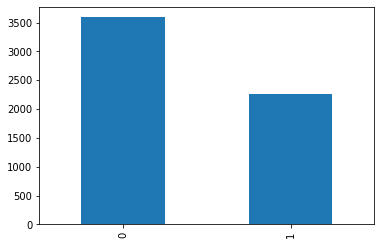

In [19]:
print(hasoc_data_df_task_a.label.value_counts())
hasoc_data_df_task_a.label.value_counts().plot(kind='bar')

### Split dataframe into train and validation

In [0]:
data_df = data_utils.Datasplitter.split_dataframe(hasoc_data_df_task_a, train_frac= 0.9, shuffle=True )

In [21]:
print(data_df.split.value_counts())
sum(data_df.label.value_counts()) == \
sum(data_df[data_df.split == 'train'].label.value_counts())\
 + sum(data_df[data_df.split == 'val'].label.value_counts())

train    5267
val       585
Name: split, dtype: int64


True

In [22]:
hasoc_data_df_task_a.label.value_counts()

0    3591
1    2261
Name: label, dtype: int64

## Create GPT2 Preprocessor
Add special tokens

In [0]:
class GPT2Preprocessor():
    """Adds special tokens to the samples"""
    def __init__(self,transformer_tokenizer,sentence_detector):
        self.transformer_tokenizer = transformer_tokenizer
        self.sentence_detector = sentence_detector
        
    def add_eos_tokens(self, text):
        eos_token = ' ' + self.transformer_tokenizer.eos_token + ' '
        sentences = self.sentence_detector.tokenize(text)
        eos_added_text  = eos_token.join(sentences) + ' ' + self.transformer_tokenizer.eos_token
        return eos_added_text 

In [28]:
 !python3 -c "import nltk; nltk.download('punkt')"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(
    'gpt2'
)
punkt_sentence_detector = nltk.data.load('tokenizers/punkt/english.pickle')

In [0]:
gpt2_preproc = GPT2Preprocessor(gpt2_tokenizer, punkt_sentence_detector)

In [32]:
data_df['text'] = data_df['text'].map(gpt2_preproc.add_eos_tokens)
print(data_df.columns)
print(data_df.label.value_counts())
print(data_df.split.value_counts())

Index(['text', 'label', 'split'], dtype='object')
0    3591
1    2261
Name: label, dtype: int64
train    5267
val       585
Name: split, dtype: int64


In [33]:
with pd.option_context('display.max_colwidth', -1): 
    print(data_df[:10])

                                                                                                                                                                                                                                                                                                                                                  text  ...  split
1840  BBMCH Balangir stand with NRSMCH  #DoctorsFightBack   #NRSMedicalCollege https://t.co/jfVN3DSfFJ <|endoftext|>                                                                                                                                                                                                                                    ...  train
1544  More evidence piles in. <|endoftext|> Happy #JohnMcCainDay #TrumpIsATraitor #TrumpCrimeFamily #Oreo #DitchMitch2020 #arrestBARR  #Vets https://t.co/1R3hhH3mxW <|endoftext|>                                                                                                                

In [0]:
dataset = transformer_data_utils.HateDataset(
    data_df = data_df,
    tokenizer = gpt2_tokenizer
)